In [99]:
import yaml
import numpy as np
from PIL import Image
from tqdm.auto import tqdm
import sklearn.utils
import skimage.color
import matplotlib.pyplot as plt
import fannypack as fp
import scipy.spatial

In [141]:
def load_dataset():
    # Load dataset YAML file
    with open("dataset/dataset.yaml", "r") as file:
        dataset = yaml.safe_load(file)

    # Load images, labels
    images = []
    labels = []
    skip_count = 0
    for sample in tqdm(dataset):
        if max(sample["labels"].values()) < 0.70:
            skip_count += 1
            continue

        label_semantic = max(sample["labels"].keys(), key=sample["labels"].get)
        label = label_semantic == "GROUND"

        rgb_path = sample["path"]
        rgb_image = np.array(Image.open(rgb_path))
        images.append(rgb_image)
        labels.append(label)

    # Shuffle dataset
    images, labels = sklearn.utils.shuffle(images, labels)

    # Convert to NumPy arrays
    images = np.array(images)
    labels = np.array(labels)

    # Return
    print(f"Loaded {len(images)} images, skipped {skip_count}!")
    return {"images": images, "labels": labels}

In [142]:
dataset = load_dataset()


Loaded 5061 images, skipped 1827!


In [143]:
# Balance dataset labels
true_indices = np.where(dataset["labels"])[0]
false_indices = np.where(np.logical_not(dataset["labels"]))[0]
mask = np.zeros(len(dataset["images"]), dtype=bool)

true_count = len(true_indices)
false_count = len(false_indices)
keep_count = min(true_count, false_count)

mask[true_indices[:keep_count]] = True
mask[false_indices[:keep_count]] = True

print(f"True count: {true_count}")
print(f"False count: {false_count}")
print(f"Keep count: {keep_count}")

dataset["images"] = dataset["images"][mask]
dataset["labels"] = dataset["labels"][mask]

True count: 3780
False count: 1281
Keep count: 1281


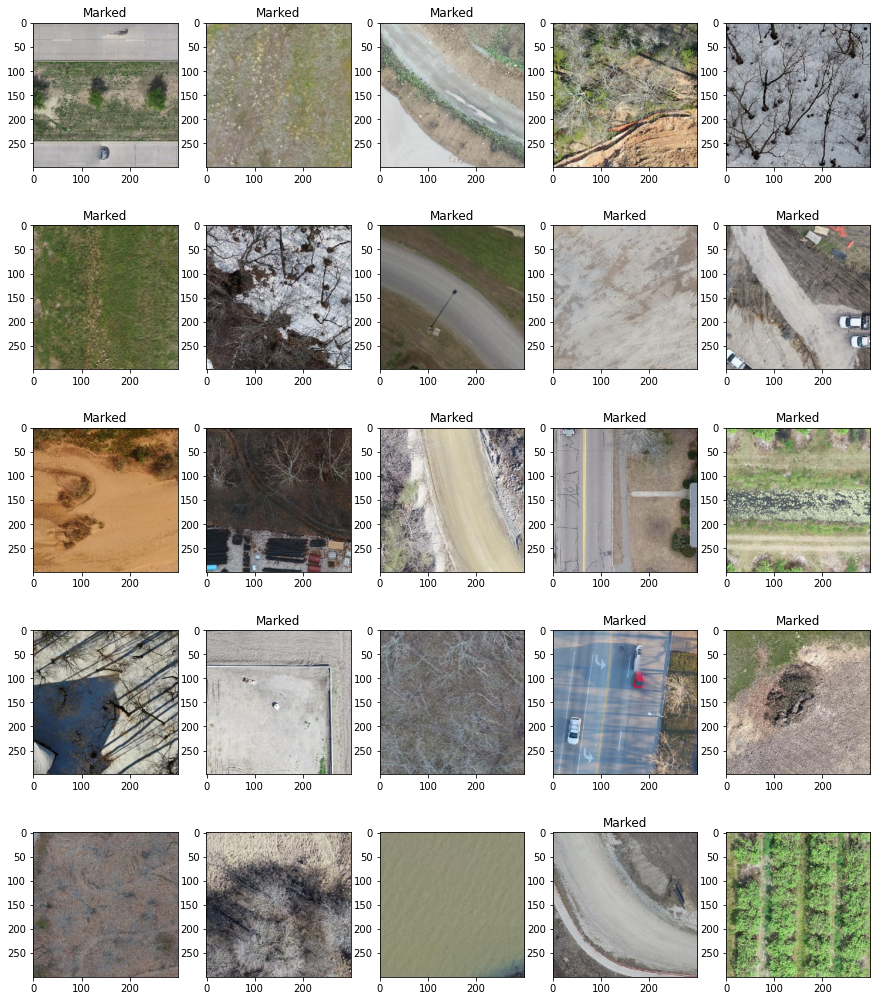

In [144]:
fig, axes = plt.subplots(5, 5, figsize=(15, 18))

for index, ax in enumerate(axes.flatten()):
    index = np.random.randint(len(dataset["images"]))
    ax.imshow(dataset["images"][index])
    ax.set_title("Marked" if dataset["labels"][index] else "")

In [145]:
# Compute features?
dataset["features"] = []
for image in tqdm(dataset["images"]):
    hsv = skimage.color.rgb2hsv(image[..., :3] / 255.0)
    features = np.mean(hsv.reshape(-1, 3), axis=0)
    dataset["features"].append(features)
dataset["features"] = np.array(dataset["features"])

In [146]:
(
    dataset["labels"],
    dataset["features"],
    dataset["images"],
) = sklearn.utils.shuffle(
    dataset["labels"], dataset["features"], dataset["images"]
)

train_count = int(len(fp.utils.SliceWrapper(dataset)) * 0.6)
train_dataset = fp.utils.SliceWrapper(dataset)[:train_count]
val_dataset = fp.utils.SliceWrapper(dataset)[train_count:]

In [147]:
def eval_knn(eval_dataset, k=3):
    samples = eval_dataset["features"]
    labels = eval_dataset["labels"]
    train_samples = train_dataset["features"]
    train_labels = train_dataset["labels"]

    distances = scipy.spatial.distance.cdist(samples, train_samples)
    assert distances.shape == (samples.shape[0], train_samples.shape[0])

    pred_labels = np.zeros_like(labels)
    confusion_matrix = np.zeros((2, 2), dtype=np.uint64)

    for i in range(len(samples)):
        closest_labels = train_labels[np.argsort(distances[i])[:k]]
        counts = np.bincount(closest_labels)
        pred_labels[i] = np.argmax(counts)

        confusion_matrix[int(labels[i]), int(pred_labels[i])] += 1

    print(confusion_matrix)
    return pred_labels

In [148]:
eval_knn(val_dataset)

None

[[399 109]
 [151 366]]
